In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from glob import glob
import copy
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from sensory_stim_lag import visual_stim_lag

In [5]:
%matplotlib notebook

### Load data

In [6]:
# dfolder = r'C:\Users\lesliec\data\eeg_pilot\mouse496220\audio_vis2_2020-06-11_11-42-47\recording1'
dfolder = r'E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)

sslog_file not found.


In [7]:
print(exp.sync_file)

E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1\mouse496220200618134906.sync


In [8]:
sync_data = exp._load_sync_dataset()

In [9]:
print(sync_data.line_labels)

['behavior_vsync', 'behavior_sweep', 'fluorescence_camera', 'behavior_camera', 'face_camera', 'eye_camera', 'capacitive_licks', 'barcodes', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


### Get sweep and vsync edges from sync file

#### Let's take a look

https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/ecephys/stimulus_table/ecephys_visual_coding_time_alignment.ipynb

### Load the stim table and log file

In [10]:
# stimulus table
stim_file = glob(exp.data_folder + '/*_table.csv', recursive=True)[0]
print(stim_file)

# log file
log_file = glob(exp.data_folder + '/*_stimulus_log.csv', recursive=True)[0]
print(log_file)

E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1\audio_vis_table.csv
E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1\2020-06-18_13-49-55_stimulus_log.csv


In [11]:
stim_table = pd.read_csv(stim_file)
stim_table.head()

,type,parameter,on_time,duration
0,fullscreen,black,1,0.25
1,auditory,whitenoise,6,0.25
2,auditory,whitenoise,11,0.25
3,fullscreen,white,16,0.25
4,auditory,whitenoise,21,0.25


In [12]:
stim_log = pd.read_csv(log_file)
stim_log.head()

,time,frame,display_stim,stim_type,stim_parameter
0,0.228516,0,False,gray_screen,none
1,0.232966,1,False,gray_screen,none
2,0.249750,2,False,gray_screen,none
3,0.266446,3,False,gray_screen,none
4,0.283012,4,False,gray_screen,none


In [13]:
print('Number of stimuli in stim_table: %d' % (len(stim_table)-1)) # -1 because of "end" line
print('Number of entries in stim_log: %d' % len(stim_log))

Number of stimuli in stim_table: 240
Number of entries in stim_log: 139659


### Check rising and falling edges

In [14]:
srising = sync_data.get_edges(keys=('behavior_sweep',), kind='rising', units='seconds')
sfalling = sync_data.get_edges(keys=('behavior_sweep',), kind='falling', units='seconds')

vrising = sync_data.get_edges(keys=('behavior_vsync',), kind='rising', units='seconds')
vfalling = sync_data.get_edges(keys=('behavior_vsync',), kind='falling', units='seconds')

In [15]:
print('behavior_sweep info')
print('number of rising/falling: %d/%d' % (len(srising), len(sfalling)))
print('first rising: %f' % srising[0])
print('first falling: %f' % sfalling[0])

behavior_sweep info
number of rising/falling: 2/2
first rising: 49.262640
first falling: 1246.283430


In [16]:
print('behavior_vsync info')
print('number of rising/falling: %d/%d' % (len(vrising), len(vfalling)))
print('first rising: %f' % vrising[0])
print('first falling: %f' % vfalling[0])

behavior_vsync info
number of rising/falling: 139659/139659
first rising: 49.265840
first falling: 49.489790


### Combine log with vsync rising and falling times

In [17]:
sync_log = stim_log.drop(labels='time', axis='columns')
sync_log['vsync_rising'] = vrising
sync_log['vsync_falling'] = vfalling
sync_log.head()

,frame,display_stim,stim_type,stim_parameter,vsync_rising,vsync_falling
0,0,False,gray_screen,none,49.26584,49.48979
1,1,False,gray_screen,none,49.49069,49.49425
2,2,False,gray_screen,none,49.49479,49.51103
3,3,False,gray_screen,none,49.51145,49.52773
4,4,False,gray_screen,none,49.52813,49.54429


In [18]:
start = time.time()
list_stim_type = []
list_stim_param = []
list_onset_times = []
list_offset_times = []
for i in range(1, len(sync_log)):
    if sync_log.stim_type.iloc[i-1] == 'gray_screen' and sync_log.stim_type.iloc[i] == 'fullscreen':
        list_onset_times.append(sync_log.vsync_falling.iloc[i]) # vsync_falling is visual stim onset
        list_stim_type.append(sync_log.stim_type.iloc[i])
        list_stim_param.append(sync_log.stim_parameter.iloc[i]) # to make sure order matches stim table
    elif sync_log.stim_type.iloc[i-1] == 'fullscreen' and sync_log.stim_type.iloc[i] == 'gray_screen':
        list_offset_times.append(sync_log.vsync_falling.iloc[i]) # gray_screen vsync_falling is visual stim offset
    elif sync_log.stim_type.iloc[i-1] == 'gray_screen' and sync_log.stim_type.iloc[i] == 'auditory':
        list_onset_times.append(sync_log.vsync_rising.iloc[i]) # vsync_rising is aditory stim onset
        list_offset_times.append(sync_log.vsync_falling.iloc[i]) # vsync_falling is aditory stim offset
        list_stim_type.append(sync_log.stim_type.iloc[i])
        list_stim_param.append(sync_log.stim_parameter.iloc[i])
end = time.time()
print('Time to loop through stim log: %0.2f seconds' % (end-start))

Time to loop through stim log: 10.08 seconds


#### Now build stim table log with vsync onset/offset times (falling edge for visual stim, rising for auditory) *** These times are not yet corrected for visual/auditory display lag.

In [19]:
vsync_log = pd.DataFrame({
    'stim_type': list_stim_type,
    'stim_parameter': list_stim_param,
    'onset': list_onset_times,
    'offset': list_offset_times
})
vsync_log.head()

,stim_type,stim_parameter,onset,offset
0,fullscreen,black,50.27826,50.54503
1,auditory,whitenoise,55.38163,55.65093
2,auditory,whitenoise,60.30197,60.57100
3,fullscreen,white,65.29150,65.55837
4,auditory,whitenoise,70.29263,70.56114


In [20]:
vsync_log['duration'] = vsync_log['offset'] - vsync_log['onset']
vsync_log.head()

,stim_type,stim_parameter,onset,offset,duration
0,fullscreen,black,50.27826,50.54503,0.26677
1,auditory,whitenoise,55.38163,55.65093,0.26930
2,auditory,whitenoise,60.30197,60.57100,0.26903
3,fullscreen,white,65.29150,65.55837,0.26687
4,auditory,whitenoise,70.29263,70.56114,0.26851


In [21]:
vis_stim = vsync_log[vsync_log['stim_type'] == 'fullscreen']
aud_stim = vsync_log[vsync_log['stim_type'] == 'auditory']

#### Now what about onset/offset lag??

In [22]:
samp_rate = sync_data.analog_meta_data['analog_sample_rate']
print(samp_rate)

10000.0


C:\Users\lesliec\AppData\Local\Continuum\miniconda3\envs\tbd_eeg\lib\site-packages\allensdk\brain_observatory\sync_dataset.py:454: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eval(self.dfile['analog_meta'].value)


Let's look at the photodiode for visual stim lags.

In [23]:
photodiode = sync_data.get_analog_channel('photodiode')
speaker_input = sync_data.get_analog_channel('speaker_input')
synctime = np.arange(0, len(photodiode))/samp_rate

<IPython.core.display.Javascript object>


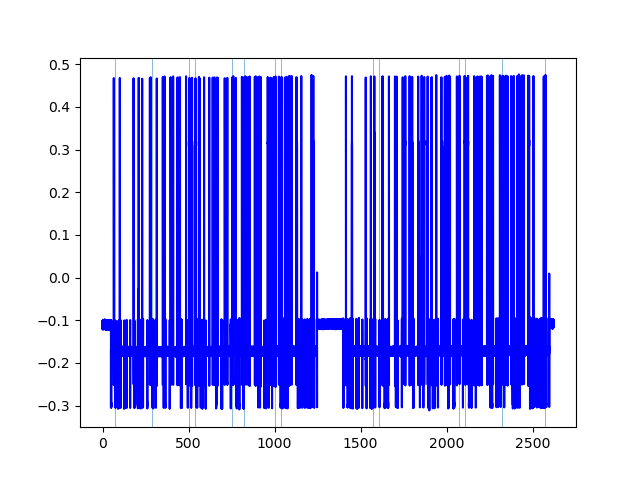

In [24]:
fig, ax = plt.subplots()
ax.plot(synctime, photodiode, 'b')

for ind, row in vis_stim.iterrows():
    ax.axvspan(row.onset, row.offset, alpha=0.5)

<IPython.core.display.Javascript object>


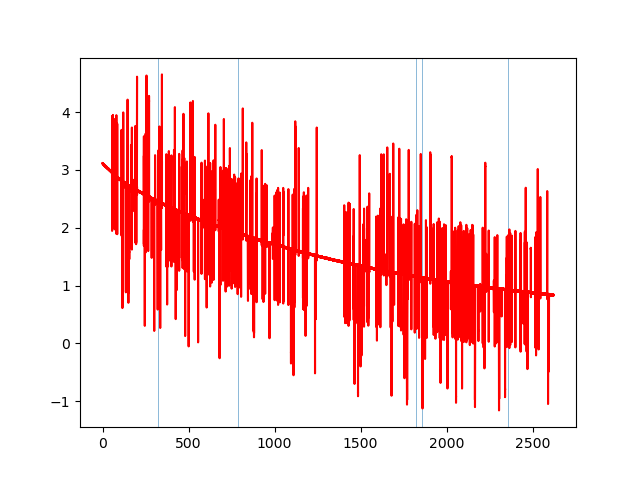

In [25]:
fig, ax = plt.subplots()
ax.plot(synctime, speaker_input, 'r')

for ind, row in aud_stim.iterrows():
    ax.axvspan(row.onset, row.offset, alpha=0.5)

Loop through all stim and look through photodiode or speaker signal to find real onset/offset times.

In [26]:
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

onset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
offset_delays = np.zeros(len(vsync_log)) # initialize array to hold delays
for ind, row in vsync_log.iterrows():
    onset_ind = int(row.onset * samp_rate)
    offset_ind = int(row.offset * samp_rate)
    
    if row.stim_type == 'fullscreen':
        onset_chunk = photodiode[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = photodiode[offset_ind - search_sample:offset_ind + search_sample]
    elif row.stim_type == 'auditory':
        onset_chunk = speaker_input[onset_ind - search_sample:onset_ind + search_sample]
        offset_chunk = speaker_input[offset_ind - search_sample:offset_ind + search_sample]
    
    # TIME stamps for chunks
    onset_t = synctime[onset_ind - search_sample:onset_ind + search_sample] - row.onset
    offset_t = synctime[offset_ind - search_sample:offset_ind + search_sample] - row.offset
    
    # ONSET DELAY
    onset_z = np.abs((onset_chunk - np.mean(onset_chunk[0:search_sample]))/np.std(onset_chunk[0:search_sample]))
    onset_z_thresh = (np.max(onset_z) - np.min(onset_z))*0.5
    onset_delays[ind] = onset_t[np.argwhere(onset_z > onset_z_thresh)[0]]
    
    # OFFSET DELAY
    offset_z = np.abs((offset_chunk - np.mean(offset_chunk[0:search_sample]))/np.std(offset_chunk[0:search_sample]))
    offset_z_thresh = (np.max(offset_z) - np.min(offset_z))*0.5
    offset_delays[ind] = offset_t[np.argwhere(offset_z > offset_z_thresh)[0]]

In [27]:
vsync_log['onset_delay'] = onset_delays
vsync_log['offset_delay'] = offset_delays

In [28]:
vsync_log

,stim_type,stim_parameter,onset,offset,duration,onset_delay,offset_delay
0,fullscreen,black,50.27826,50.54503,0.26677,0.03224,0.03717
1,auditory,whitenoise,55.38163,55.65093,0.26930,0.02017,-0.10003
2,auditory,whitenoise,60.30197,60.57100,0.26903,0.02073,-0.10000
3,fullscreen,white,65.29150,65.55837,0.26687,0.03100,0.03123
4,auditory,whitenoise,70.29263,70.56114,0.26851,0.01947,-0.09984
...,...,...,...,...,...,...,...
475,fullscreen,white,2575.05393,2575.32079,0.26686,0.03097,0.03121
476,fullscreen,black,2580.05778,2580.32464,0.26686,0.03022,0.03546
477,auditory,10000,2585.04611,2585.31515,0.26904,0.02249,-0.00155
478,auditory,10000,2590.05005,2590.31534,0.26529,0.01855,-0.00174


### From previous analysis:

### Get analog speaker_input to check auditory delay

### How to threshold analog speaker signal?

What about a rolling z-score? Window should be longer than stimuli duration, 250 ms.

In [22]:
# AUDITORY SIGNAL

search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

aud_delays = np.zeros(len(aud_stim)) # initialize array to hold delays
for ind, sync_aud_onset in enumerate(aud_stim['onset']):
    onset_ind = int(sync_aud_onset * samp_rate)
    
    speaker_input_chunk = speaker_input[onset_ind - search_sample:onset_ind + search_sample]
    BL = np.mean(speaker_input_chunk[0:search_sample])
    STD = np.std(speaker_input_chunk[0:search_sample])
    chunk_z = np.abs((speaker_input_chunk - BL)/STD)
    timex = synctime[onset_ind - search_sample:onset_ind + search_sample] - sync_aud_onset
    
    z_thresh = (np.max(chunk_z) - np.min(chunk_z))*0.5

    aud_delays[ind] = timex[np.argwhere(chunk_z > z_thresh)[0]]

In [22]:
# VISUAL SIGNAL

search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

vis_delays = np.zeros(len(vis_stim)) # initialize array to hold delays
for ind, sync_vis_onset in enumerate(vis_stim['onset']):
    onset_ind = int(sync_vis_onset * samp_rate)
    
    photodiode_chunk = photodiode[onset_ind - search_sample:onset_ind + search_sample]
    BL = np.mean(photodiode_chunk[0:search_sample])
    STD = np.std(photodiode_chunk[0:search_sample])
    chunk_z = np.abs((photodiode_chunk - BL)/STD)
    timex = synctime[onset_ind - search_sample:onset_ind + search_sample] - sync_vis_onset
    
    z_thresh = (np.max(chunk_z) - np.min(chunk_z))*0.5

    vis_delays[ind] = timex[np.argwhere(chunk_z > z_thresh)[0]]

<IPython.core.display.Javascript object>


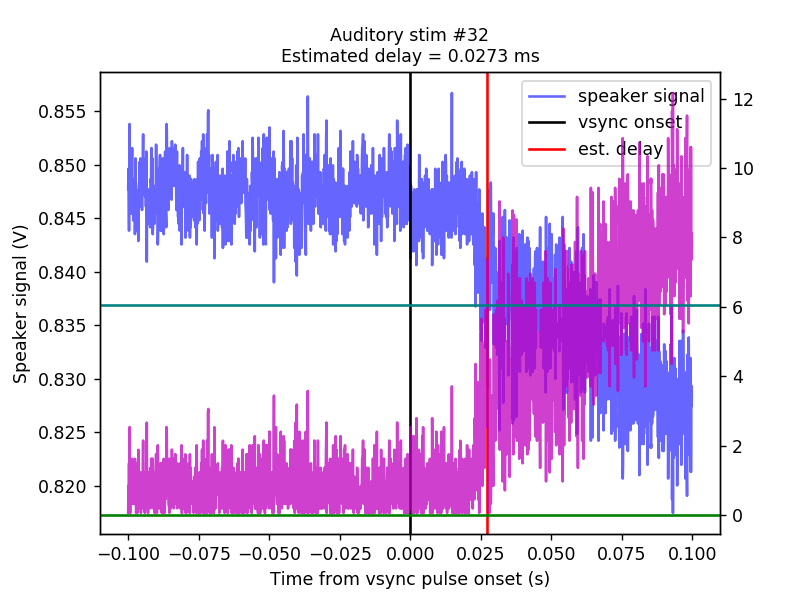

In [30]:
numind = 32
test_onset = aud_stim['onset'].iloc[numind]

onset_sample = int(test_onset * samp_rate)
search_window = 0.1 # s, before and after
search_sample = int(search_window * samp_rate)

speaker_chunk = speaker_input[onset_sample - search_sample:onset_sample + search_sample]
BL = np.mean(speaker_chunk[0:search_sample])
STD = np.std(speaker_chunk[0:search_sample])
chunkz = np.abs((speaker_chunk-BL)/STD)
timex = synctime[onset_sample - search_sample:onset_sample + search_sample] - test_onset
z_thresh = (np.max(chunkz) - np.min(chunkz))/2
delay = timex[np.argwhere(chunkz > z_thresh)[0]]

half_window = 10
rolling_std = np.zeros(len(speaker_chunk))
amp = np.zeros(len(speaker_chunk))
for ii in range(len(rolling_std)):
    center_sample = onset_sample + ii
    rolling_std[ii] = np.std(speaker_input[center_sample - half_window:center_sample + half_window])
    amp[ii] = np.max(speaker_input[center_sample - half_window:center_sample + half_window]) - np.min(speaker_input[center_sample - half_window:center_sample + half_window])

fig, ax = plt.subplots()
ax.plot(timex, speaker_chunk, 'b', alpha=0.6, label='speaker signal')
ax1 = ax.twinx()
ax1.plot(timex, chunkz, 'm', alpha=0.75)
# ax1.set_ylim([0, 0.02])
ax.axvline(x=0, c='black', label='vsync onset')
ax.axvline(x=delay, c='red', label='est. delay')
ax1.axhline(y=STD, c='green', label='baseline std')
ax1.axhline(y=z_thresh, c='teal', label='threshold')
ax.set_title('Auditory stim #%d\nEstimated delay = %0.4f ms' % (numind, delay))
ax.set_xlabel('Time from vsync pulse onset (s)')
ax.set_ylabel('Speaker signal (V)')
ax.legend()

In [26]:
# aud_delays[32] = 0.023
# aud_delays[144] = 0.015

In [27]:
print('Mean auditory delay = %0.3f ms' % (np.mean(aud_delays)*1000))
print('Auditory delay standard deviation = %0.5f ms' % (np.std(aud_delays)*1000))
print('Auditory delay max = %0.3f ms' % (np.max(aud_delays)*1000))
print('Auditory delay min = %0.3f ms' % (np.min(aud_delays)*1000))

Mean auditory delay = 17.343 ms
Auditory delay standard deviation = 3.25681 ms
Auditory delay max = 27.330 ms
Auditory delay min = 10.970 ms


### Testing Irene's visual_stim_lag function

<IPython.core.display.Javascript object>


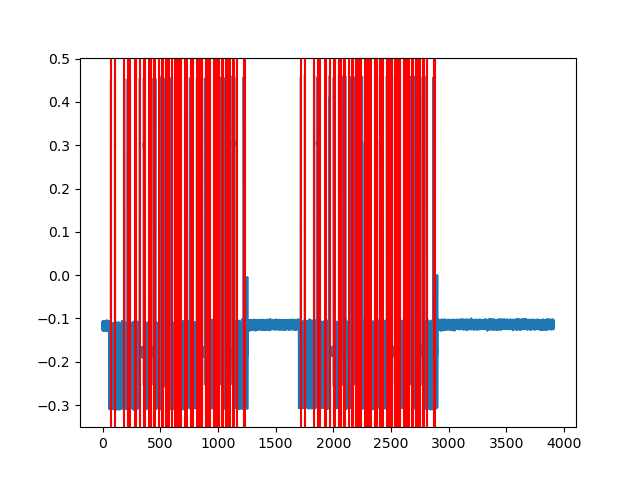

In [25]:
vislagmean, vislagstd = visual_stim_lag(photodiode, log_file, vfalling, flag_plot=1)

In [26]:
print(vislagmean)
print(vislagstd)

30.60616666672592
0.04827323849252103
